# Лабораторная работа 1: выполнил Шиширин В.Н. М8О-310Б-23

## План работы
1. Анализ данных
2. Создание признаков
3. Обучение модели
4. Оценка результатов

In [555]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (11017, 35)
Test shape: (5000, 35)


## 1. Анализ данных

## Реализация методов нормализации

Реализуем z-score и min-max нормализацию вручную и сравниваем с sklearn.

In [556]:
# Реализация z-score нормализации
def z_score_normalization(X):
    """Нормализация z-score вручную"""
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    # Чтобы не делить на 0
    std[std == 0] = 1
    return (X - mean) / std, mean, std

# Реализация min-max нормализации
def min_max_normalization(X):
    """Нормализация min-max вручную"""
    min_val = np.min(X, axis=0)
    max_val = np.max(X, axis=0)
    # Чтобы не делить на 0
    range_val = max_val - min_val
    range_val[range_val == 0] = 1
    return (X - min_val) / range_val, min_val, max_val

# Тестируем на небольшом примере
test_data = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])

# Моя z-score
my_zscore, _, _ = z_score_normalization(test_data)

# sklearn z-score
from sklearn.preprocessing import StandardScaler
sklearn_scaler = StandardScaler()
sklearn_zscore = sklearn_scaler.fit_transform(test_data)

# Моя min-max
my_minmax, _, _ = min_max_normalization(test_data)

# sklearn min-max
from sklearn.preprocessing import MinMaxScaler
sklearn_mm = MinMaxScaler()
sklearn_minmax = sklearn_mm.fit_transform(test_data)

print("Сравнение z-score:")
print(f"Моя реализация:\n{my_zscore}")
print(f"Sklearn:\n{sklearn_zscore}")
print(f"Разница: {np.abs(my_zscore - sklearn_zscore).max():.10f}")

print("\nСравнение min-max:")
print(f"Моя реализация:\n{my_minmax}")
print(f"Sklearn:\n{sklearn_minmax}")
print(f"Разница: {np.abs(my_minmax - sklearn_minmax).max():.10f}")

Сравнение z-score:
Моя реализация:
[[-1.34164079 -1.34164079]
 [-0.4472136  -0.4472136 ]
 [ 0.4472136   0.4472136 ]
 [ 1.34164079  1.34164079]]
Sklearn:
[[-1.34164079 -1.34164079]
 [-0.4472136  -0.4472136 ]
 [ 0.4472136   0.4472136 ]
 [ 1.34164079  1.34164079]]
Разница: 0.0000000000

Сравнение min-max:
Моя реализация:
[[0.         0.        ]
 [0.33333333 0.33333333]
 [0.66666667 0.66666667]
 [1.         1.        ]]
Sklearn:
[[0.         0.        ]
 [0.33333333 0.33333333]
 [0.66666667 0.66666667]
 [1.         1.        ]]
Разница: 0.0000000000


## Реализация метрик качества

Реализуем MSE, MAE, R² и MAPE вручную.

In [557]:
# Реализация MSE
def my_mse(y_true, y_pred):
    """Mean Squared Error"""
    return np.mean((y_true - y_pred) ** 2)

# Реализация MAE
def my_mae(y_true, y_pred):
    """Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))

# Реализация R²
def my_r2(y_true, y_pred):
    """R-squared (коэффициент детерминации)"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Реализация MAPE
def my_mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    # Избегаем деления на 0
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Тестируем метрики
y_true_test = np.array([3, -0.5, 2, 7])
y_pred_test = np.array([2.5, 0.0, 2, 8])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Сравнение метрик на тестовых данных:")
print("\nMSE:")
print(f"  Моя: {my_mse(y_true_test, y_pred_test):.10f}")
print(f"  Sklearn: {mean_squared_error(y_true_test, y_pred_test):.10f}")

print("\nMAE:")
print(f"  Моя: {my_mae(y_true_test, y_pred_test):.10f}")
print(f"  Sklearn: {mean_absolute_error(y_true_test, y_pred_test):.10f}")

print("\nR²:")
print(f"  Моя: {my_r2(y_true_test, y_pred_test):.10f}")
print(f"  Sklearn: {r2_score(y_true_test, y_pred_test):.10f}")

print("\nMAPE:")
print(f"  Моя: {my_mape(y_true_test, y_pred_test):.10f}%")

Сравнение метрик на тестовых данных:

MSE:
  Моя: 0.3750000000
  Sklearn: 0.3750000000

MAE:
  Моя: 0.5000000000
  Sklearn: 0.5000000000

R²:
  Моя: 0.9486081370
  Sklearn: 0.9486081370

MAPE:
  Моя: 32.7380952381%


## Реализация класса линейной регрессии

Реализуем линейную регрессию через аналитическую формулу, градиентный спуск и стохастический градиентный спуск.

In [558]:
class MyLinearRegression:
    """Линейная регрессия с несколькими методами обучения"""
    
    def __init__(self, method='normal', learning_rate=0.01, n_iterations=1000, batch_size=32):
        """
        method: 'normal' - аналитическое решение
                'gd' - градиентный спуск
                'sgd' - стохастический градиентный спуск
        """
        self.method = method
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        """Обучение модели"""
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        
        if self.method == 'normal':
            # Аналитическое решение: w = (X^T X)^(-1) X^T y
            X_b = np.c_[np.ones((n_samples, 1)), X]  # добавляем столбец единиц для bias
            theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
            self.bias = theta[0]
            self.weights = theta[1:]
            
        elif self.method == 'gd':
            # Градиентный спуск
            self.weights = np.zeros(n_features)
            self.bias = 0
            
            for _ in range(self.n_iterations):
                y_pred = self.predict(X)
                
                # Вычисляем градиенты
                dw = -(2/n_samples) * X.T.dot(y - y_pred)
                db = -(2/n_samples) * np.sum(y - y_pred)
                
                # Обновляем веса
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
        elif self.method == 'sgd':
            # Стохастический градиентный спуск
            self.weights = np.zeros(n_features)
            self.bias = 0
            
            for _ in range(self.n_iterations):
                # Перемешиваем данные
                indices = np.random.permutation(n_samples)
                X_shuffled = X[indices]
                y_shuffled = y[indices]
                
                # Проходим по мини-батчам
                for i in range(0, n_samples, self.batch_size):
                    X_batch = X_shuffled[i:i+self.batch_size]
                    y_batch = y_shuffled[i:i+self.batch_size]
                    
                    y_pred = self.predict(X_batch)
                    batch_size = len(X_batch)
                    
                    # Градиенты
                    dw = -(2/batch_size) * X_batch.T.dot(y_batch - y_pred)
                    db = -(2/batch_size) * np.sum(y_batch - y_pred)
                    
                    # Обновляем веса
                    self.weights -= self.learning_rate * dw
                    self.bias -= self.learning_rate * db
        
        return self
    
    def predict(self, X):
        """Предсказание"""
        return np.dot(X, self.weights) + self.bias

# Тестируем на простых данных
np.random.seed(42)
X_simple = np.random.randn(100, 3)
y_simple = 3*X_simple[:, 0] + 2*X_simple[:, 1] - X_simple[:, 2] + 5 + np.random.randn(100)*0.5

print("Сравнение методов на синтетических данных:\n")

# Аналитическое решение
model_normal = MyLinearRegression(method='normal')
model_normal.fit(X_simple, y_simple)
y_pred_normal = model_normal.predict(X_simple)
print(f"Аналитическое решение:")
print(f"  MSE: {my_mse(y_simple, y_pred_normal):.6f}")
print(f"  Веса: {model_normal.weights}")
print(f"  Bias: {model_normal.bias:.6f}")

# Градиентный спуск
model_gd = MyLinearRegression(method='gd', learning_rate=0.1, n_iterations=1000)
model_gd.fit(X_simple, y_simple)
y_pred_gd = model_gd.predict(X_simple)
print(f"\nГрадиентный спуск:")
print(f"  MSE: {my_mse(y_simple, y_pred_gd):.6f}")
print(f"  Веса: {model_gd.weights}")
print(f"  Bias: {model_gd.bias:.6f}")

# Стохастический градиентный спуск
model_sgd = MyLinearRegression(method='sgd', learning_rate=0.1, n_iterations=100, batch_size=16)
model_sgd.fit(X_simple, y_simple)
y_pred_sgd = model_sgd.predict(X_simple)
print(f"\nСтохастический градиентный спуск:")
print(f"  MSE: {my_mse(y_simple, y_pred_sgd):.6f}")
print(f"  Веса: {model_sgd.weights}")
print(f"  Bias: {model_sgd.bias:.6f}")

# Sklearn для сравнения
from sklearn.linear_model import LinearRegression
sklearn_model = LinearRegression()
sklearn_model.fit(X_simple, y_simple)
y_pred_sklearn = sklearn_model.predict(X_simple)
print(f"\nSklearn LinearRegression:")
print(f"  MSE: {my_mse(y_simple, y_pred_sklearn):.6f}")
print(f"  Веса: {sklearn_model.coef_}")
print(f"  Bias: {sklearn_model.intercept_:.6f}")

Сравнение методов на синтетических данных:

Аналитическое решение:
  MSE: 0.189191
  Веса: [ 2.96116836  1.97501822 -1.05379666]
  Bias: 5.056431

Градиентный спуск:
  MSE: 0.189191
  Веса: [ 2.96116836  1.97501822 -1.05379666]
  Bias: 5.056431

Стохастический градиентный спуск:
  MSE: 0.194333
  Веса: [ 2.97439016  1.95190473 -1.11456951]
  Bias: 5.068314

Sklearn LinearRegression:
  MSE: 0.189191
  Веса: [ 2.96116836  1.97501822 -1.05379666]
  Bias: 5.056431


## Реализация кросс-валидации

Реализуем k-fold и leave-one-out кросс-валидацию.

In [559]:
def my_kfold_cv(X, y, model, k=5, metric_fn=my_mse):
    """K-Fold кросс-валидация"""
    n_samples = len(X)
    fold_size = n_samples // k
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    scores = []
    
    for i in range(k):
        # Разделяем на train и validation
        val_start = i * fold_size
        val_end = (i + 1) * fold_size if i < k - 1 else n_samples
        
        val_indices = indices[val_start:val_end]
        train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
        
        X_train_fold = X[train_indices]
        y_train_fold = y[train_indices]
        X_val_fold = X[val_indices]
        y_val_fold = y[val_indices]
        
        # Обучаем и предсказываем
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        
        # Считаем метрику
        score = metric_fn(y_val_fold, y_pred)
        scores.append(score)
    
    return np.array(scores)

def my_loocv(X, y, model, metric_fn=my_mse):
    """Leave-One-Out кросс-валидация"""
    n_samples = len(X)
    scores = []
    
    for i in range(n_samples):
        # Убираем один элемент для валидации
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i)
        X_val = X[i:i+1]
        y_val = y[i:i+1]
        
        # Обучаем и предсказываем
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        # Считаем метрику
        score = metric_fn(y_val, y_pred)
        scores.append(score)
    
    return np.array(scores)

# Тестируем на небольшом датасете
X_cv_test = X_simple[:50]
y_cv_test = y_simple[:50]

print("Тестирование кросс-валидации:\n")

# K-Fold с нашей реализацией
model_test = MyLinearRegression(method='normal')
my_kfold_scores = my_kfold_cv(X_cv_test, y_cv_test, model_test, k=5)
print(f"Моя K-Fold (k=5):")
print(f"  Scores: {my_kfold_scores}")
print(f"  Mean MSE: {my_kfold_scores.mean():.6f} (+/- {my_kfold_scores.std():.6f})")

# K-Fold sklearn для сравнения
from sklearn.model_selection import cross_val_score, KFold
sklearn_kf = KFold(n_splits=5, shuffle=True, random_state=42)
sklearn_scores = -cross_val_score(LinearRegression(), X_cv_test, y_cv_test, 
                                  cv=sklearn_kf, scoring='neg_mean_squared_error')
print(f"\nSklearn K-Fold (k=5):")
print(f"  Mean MSE: {sklearn_scores.mean():.6f} (+/- {sklearn_scores.std():.6f})")

# Leave-One-Out на очень маленьком датасете (иначе долго)
X_loo_test = X_simple[:20]
y_loo_test = y_simple[:20]
model_loo = MyLinearRegression(method='normal')
my_loo_scores = my_loocv(X_loo_test, y_loo_test, model_loo)
print(f"\nМоя Leave-One-Out (n=20):")
print(f"  Mean MSE: {my_loo_scores.mean():.6f} (+/- {my_loo_scores.std():.6f})")

# Sklearn LOO
from sklearn.model_selection import LeaveOneOut
sklearn_loo = LeaveOneOut()
sklearn_loo_scores = -cross_val_score(LinearRegression(), X_loo_test, y_loo_test, 
                                      cv=sklearn_loo, scoring='neg_mean_squared_error')
print(f"\nSklearn Leave-One-Out (n=20):")
print(f"  Mean MSE: {sklearn_loo_scores.mean():.6f} (+/- {sklearn_loo_scores.std():.6f})")

Тестирование кросс-валидации:

Моя K-Fold (k=5):
  Scores: [0.1757781  0.17181217 0.11833156 0.13926956 0.20927438]
  Mean MSE: 0.162893 (+/- 0.031434)

Sklearn K-Fold (k=5):
  Mean MSE: 0.167374 (+/- 0.049017)

Моя Leave-One-Out (n=20):
  Mean MSE: 0.147139 (+/- 0.143904)

Sklearn Leave-One-Out (n=20):
  Mean MSE: 0.147139 (+/- 0.143904)


## Реализация линейной регрессии с регуляризацией

Реализуем L1 (Lasso), L2 (Ridge), L1+L2 (ElasticNet) и Lp регуляризацию.

In [560]:
class MyRegularizedLinearRegression:
    """Линейная регрессия с регуляризацией L1, L2, L1+L2 и Lp"""
    
    def __init__(self, reg_type='l2', alpha=1.0, l1_ratio=0.5, p=2, 
                 learning_rate=0.01, n_iterations=1000):
        """
        reg_type: 'l1' (Lasso), 'l2' (Ridge), 'elastic' (L1+L2), 'lp'
        alpha: коэффициент регуляризации
        l1_ratio: соотношение L1 в ElasticNet (0 - чистый L2, 1 - чистый L1)
        p: степень для Lp регуляризации
        """
        self.reg_type = reg_type
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.p = p
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        """Обучение через градиентный спуск"""
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        
        # Инициализация весов
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iterations):
            # Предсказания
            y_pred = self.predict(X)
            
            # Базовые градиенты
            dw = -(2/n_samples) * X.T.dot(y - y_pred)
            db = -(2/n_samples) * np.sum(y - y_pred)
            
            # Добавляем регуляризацию
            if self.reg_type == 'l2':
                # L2: добавляем 2 * alpha * w
                dw += 2 * self.alpha * self.weights
                
            elif self.reg_type == 'l1':
                # L1: добавляем alpha * sign(w)
                dw += self.alpha * np.sign(self.weights)
                
            elif self.reg_type == 'elastic':
                # ElasticNet: L1 + L2
                l1_term = self.alpha * self.l1_ratio * np.sign(self.weights)
                l2_term = self.alpha * (1 - self.l1_ratio) * 2 * self.weights
                dw += l1_term + l2_term
                
            elif self.reg_type == 'lp':
                # Lp регуляризация: alpha * p * |w|^(p-1) * sign(w)
                # Для избежания деления на 0
                w_abs = np.abs(self.weights) + 1e-8
                lp_grad = self.alpha * self.p * np.power(w_abs, self.p - 1) * np.sign(self.weights)
                dw += lp_grad
            
            # Обновляем веса
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
        return self
    
    def predict(self, X):
        """Предсказание"""
        return np.dot(X, self.weights) + self.bias

# Тестируем регуляризацию на данных с мультиколлинеарностью
np.random.seed(42)
X_reg = np.random.randn(100, 5)
# Добавляем коррелирующие признаки
X_reg[:, 3] = X_reg[:, 0] + np.random.randn(100) * 0.1
X_reg[:, 4] = X_reg[:, 1] + np.random.randn(100) * 0.1
y_reg = 3*X_reg[:, 0] + 2*X_reg[:, 1] + np.random.randn(100)*0.5

print("Сравнение моделей с регуляризацией:\n")

# Без регуляризации
model_no_reg = MyLinearRegression(method='normal')
model_no_reg.fit(X_reg, y_reg)
y_pred_no_reg = model_no_reg.predict(X_reg)
print(f"Без регуляризации:")
print(f"  MSE: {my_mse(y_reg, y_pred_no_reg):.6f}")
print(f"  L2 norm весов: {np.linalg.norm(model_no_reg.weights):.6f}")

# L2 (Ridge)
model_l2 = MyRegularizedLinearRegression(reg_type='l2', alpha=1.0, learning_rate=0.1, n_iterations=1000)
model_l2.fit(X_reg, y_reg)
y_pred_l2 = model_l2.predict(X_reg)
print(f"\nL2 (Ridge, alpha=1.0):")
print(f"  MSE: {my_mse(y_reg, y_pred_l2):.6f}")
print(f"  L2 norm весов: {np.linalg.norm(model_l2.weights):.6f}")

# L1 (Lasso)
model_l1 = MyRegularizedLinearRegression(reg_type='l1', alpha=0.1, learning_rate=0.1, n_iterations=1000)
model_l1.fit(X_reg, y_reg)
y_pred_l1 = model_l1.predict(X_reg)
print(f"\nL1 (Lasso, alpha=0.1):")
print(f"  MSE: {my_mse(y_reg, y_pred_l1):.6f}")
print(f"  Ненулевых весов: {np.sum(np.abs(model_l1.weights) > 0.01)}/{len(model_l1.weights)}")
print(f"  Веса: {model_l1.weights}")

# ElasticNet (L1 + L2)
model_elastic = MyRegularizedLinearRegression(reg_type='elastic', alpha=0.5, l1_ratio=0.5, 
                                              learning_rate=0.1, n_iterations=1000)
model_elastic.fit(X_reg, y_reg)
y_pred_elastic = model_elastic.predict(X_reg)
print(f"\nElasticNet (alpha=0.5, l1_ratio=0.5):")
print(f"  MSE: {my_mse(y_reg, y_pred_elastic):.6f}")
print(f"  Ненулевых весов: {np.sum(np.abs(model_elastic.weights) > 0.01)}/{len(model_elastic.weights)}")

# Lp регуляризация с p=1.5
model_lp = MyRegularizedLinearRegression(reg_type='lp', alpha=0.5, p=1.5, 
                                         learning_rate=0.1, n_iterations=1000)
model_lp.fit(X_reg, y_reg)
y_pred_lp = model_lp.predict(X_reg)
print(f"\nLp (p=1.5, alpha=0.5):")
print(f"  MSE: {my_mse(y_reg, y_pred_lp):.6f}")
print(f"  Lp norm весов: {np.sum(np.abs(model_lp.weights)**1.5):.6f}")

# Сравнение со sklearn
from sklearn.linear_model import Ridge, Lasso, ElasticNet as SklearnElasticNet

sklearn_ridge = Ridge(alpha=1.0)
sklearn_ridge.fit(X_reg, y_reg)
print(f"\nSklearn Ridge (alpha=1.0):")
print(f"  MSE: {my_mse(y_reg, sklearn_ridge.predict(X_reg)):.6f}")
print(f"  L2 norm весов: {np.linalg.norm(sklearn_ridge.coef_):.6f}")

Сравнение моделей с регуляризацией:

Без регуляризации:
  MSE: 0.229981
  L2 norm весов: 3.563932

L2 (Ridge, alpha=1.0):
  MSE: 1.810531
  L2 norm весов: 1.495542

L1 (Lasso, alpha=0.1):
  MSE: 0.241664
  Ненулевых весов: 3/5
  Веса: [1.90281899e+00 1.89932716e+00 1.43295611e-03 1.02272731e+00
 7.58939325e-03]

ElasticNet (alpha=0.5, l1_ratio=0.5):
  MSE: 0.648156
  Ненулевых весов: 4/5

Lp (p=1.5, alpha=0.5):
  MSE: 0.641303
  Lp norm весов: 3.992140

Sklearn Ridge (alpha=1.0):
  MSE: 0.243942
  L2 norm весов: 2.642942


## Сводка реализованных заданий

Проверка всех реализованных методов на учебном примере.

In [561]:
# Создаем учебный датасет
np.random.seed(123)
X_demo = np.random.randn(200, 4)
y_demo = 2*X_demo[:, 0] + 3*X_demo[:, 1] - X_demo[:, 2] + 0.5*X_demo[:, 3] + 10 + np.random.randn(200)*0.8

X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(
    X_demo, y_demo, test_size=0.3, random_state=42
)

print(f"\nУчебный датасет: {X_train_demo.shape[0]} train, {X_test_demo.shape[0]} test samples")
print("\n" + "-"*80)

# 1. Нормализация
print("\n1. НОРМАЛИЗАЦИЯ")
print("-"*80)
X_zscore, _, _ = z_score_normalization(X_train_demo)
X_minmax, _, _ = min_max_normalization(X_train_demo)
print(" Z-score нормализация реализована")
print(" Min-max нормализация реализована")

# 2. Метрики
print("\n2. МЕТРИКИ")
print("-"*80)
model_metrics = MyLinearRegression(method='normal')
model_metrics.fit(X_train_demo, y_train_demo)
y_pred_metrics = model_metrics.predict(X_test_demo)

print(f" MSE реализована:  {my_mse(y_test_demo, y_pred_metrics):.4f}")
print(f" MAE реализована:  {my_mae(y_test_demo, y_pred_metrics):.4f}")
print(f" R² реализована:   {my_r2(y_test_demo, y_pred_metrics):.4f}")
print(f" MAPE реализована: {my_mape(y_test_demo, y_pred_metrics):.4f}%")

# 3. Линейная регрессия
print("\n3. КЛАСС ЛИНЕЙНОЙ РЕГРЕССИИ")
print("-"*80)
methods = ['normal', 'gd', 'sgd']
for method in methods:
    if method == 'sgd':
        model_lr = MyLinearRegression(method=method, learning_rate=0.1, n_iterations=100)
    else:
        model_lr = MyLinearRegression(method=method, learning_rate=0.1, n_iterations=1000)
    model_lr.fit(X_train_demo, y_train_demo)
    y_pred_lr = model_lr.predict(X_test_demo)
    mse = my_mse(y_test_demo, y_pred_lr)
    
    method_names = {'normal': 'Аналитическая формула', 'gd': 'Градиентный спуск', 'sgd': 'Стохастический ГС'}
    print(f" {method_names[method]:25s} MSE: {mse:.4f}")

# Сравнение с sklearn
sklearn_lr = LinearRegression()
sklearn_lr.fit(X_train_demo, y_train_demo)
y_pred_sklearn = sklearn_lr.predict(X_test_demo)
print(f"  Sklearn LinearRegression:     MSE: {my_mse(y_test_demo, y_pred_sklearn):.4f}")

# 4. Кросс-валидация
print("\n4. КРОСС-ВАЛИДАЦИЯ")
print("-"*80)
model_cv = MyLinearRegression(method='normal')
kfold_scores = my_kfold_cv(X_train_demo, y_train_demo, model_cv, k=5)
print(f" K-Fold (k=5):       MSE = {kfold_scores.mean():.4f} (+/- {kfold_scores.std():.4f})")

# LOO на небольшой выборке
X_loo_demo = X_train_demo[:30]
y_loo_demo = y_train_demo[:30]
loo_scores = my_loocv(X_loo_demo, y_loo_demo, model_cv)
print(f" Leave-One-Out (n=30): MSE = {loo_scores.mean():.4f} (+/- {loo_scores.std():.4f})")

# 5. Регуляризация
print("\n5. РЕГУЛЯРИЗАЦИЯ")
print("-"*80)
reg_models = [
    ('L2 (Ridge)', 'l2', 1.0, None),
    ('L1 (Lasso)', 'l1', 0.1, None),
    ('L1+L2 (ElasticNet)', 'elastic', 0.5, 0.5),
    ('Lp (p=1.5)', 'lp', 0.5, 1.5)
]

for name, reg_type, alpha, param in reg_models:
    if reg_type == 'elastic':
        model_reg = MyRegularizedLinearRegression(reg_type=reg_type, alpha=alpha, l1_ratio=param,
                                                  learning_rate=0.1, n_iterations=1000)
    elif reg_type == 'lp':
        model_reg = MyRegularizedLinearRegression(reg_type=reg_type, alpha=alpha, p=param,
                                                  learning_rate=0.1, n_iterations=1000)
    else:
        model_reg = MyRegularizedLinearRegression(reg_type=reg_type, alpha=alpha,
                                                  learning_rate=0.1, n_iterations=1000)
    
    model_reg.fit(X_train_demo, y_train_demo)
    y_pred_reg = model_reg.predict(X_test_demo)
    mse = my_mse(y_test_demo, y_pred_reg)
    print(f" {name:25s} MSE: {mse:.4f}")


Учебный датасет: 140 train, 60 test samples

--------------------------------------------------------------------------------

1. НОРМАЛИЗАЦИЯ
--------------------------------------------------------------------------------
 Z-score нормализация реализована
 Min-max нормализация реализована

2. МЕТРИКИ
--------------------------------------------------------------------------------
 MSE реализована:  0.6003
 MAE реализована:  0.6034
 R² реализована:   0.9498
 MAPE реализована: 5.9763%

3. КЛАСС ЛИНЕЙНОЙ РЕГРЕССИИ
--------------------------------------------------------------------------------
 Аналитическая формула     MSE: 0.6003
 Градиентный спуск         MSE: 0.6003
 Стохастический ГС         MSE: 0.6456
  Sklearn LinearRegression:     MSE: 0.6003

4. КРОСС-ВАЛИДАЦИЯ
--------------------------------------------------------------------------------
 K-Fold (k=5):       MSE = 0.6239 (+/- 0.1359)
 Leave-One-Out (n=30): MSE = 0.5188 (+/- 0.5082)

5. РЕГУЛЯРИЗАЦИЯ
-----------------------

Пропущенные значения:
MonthlyDebtPayments           1031
LoanAmount                    1031
CreditScore                   1031
BaseInterestRate              1031
NetWorth                      1031
TotalAssets                   1031
BankruptcyHistory             1031
LoanPurpose                   1031
CheckingAccountBalance        1031
ApplicationDate                530
Age                            530
AnnualIncome                   530
HomeOwnershipStatus            530
NumberOfCreditInquiries        530
NumberOfOpenCreditLines        530
CreditCardUtilizationRate      530
NumberOfDependents             530
MaritalStatus                  530
LoanDuration                   530
LengthOfCreditHistory          530
PaymentHistory                 530
PreviousLoanDefaults           530
DebtToIncomeRatio              530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
SavingsAccountBalance          530
TotalLiabilities               530
EmploymentStatus               53

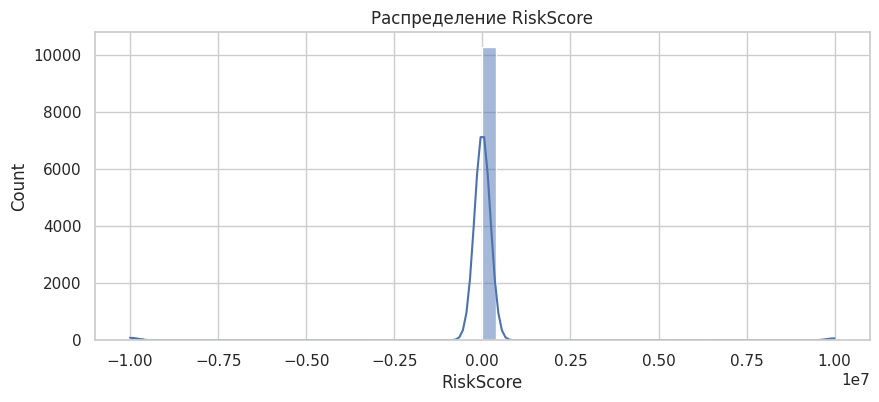


Статистика RiskScore:
count    1.048700e+04
mean    -2.569878e+04
std      1.431675e+06
min     -9.999999e+06
25%      3.256475e+01
50%      4.411876e+01
75%      6.535690e+01
max      1.000000e+07
Name: RiskScore, dtype: float64


In [562]:
# Проверяем пропущенные значения
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Пропущенные значения:")
print(missing)

# Распределение целевой переменной
plt.figure(figsize=(10, 4))
sns.histplot(train['RiskScore'].dropna(), kde=True, bins=50)
plt.title('Распределение RiskScore')
plt.xlabel('RiskScore')
plt.show()

print(f"\nСтатистика RiskScore:")
print(train['RiskScore'].describe())

In [563]:
# Анализ корреляций
numeric_cols = train.select_dtypes(include=[np.number]).columns
corr_with_target = train[numeric_cols].corr()['RiskScore'].abs().sort_values(ascending=False)
print("\nТоп-15 признаков по корреляции с RiskScore:")
print(corr_with_target.head(15))


Топ-15 признаков по корреляции с RiskScore:
RiskScore                     1.000000
NumberOfDependents            0.023314
PaymentHistory                0.019144
TotalDebtToIncomeRatio        0.013879
UtilityBillsPaymentHistory    0.013865
MonthlyLoanPayment            0.012366
LoanAmount                    0.011771
NumberOfCreditInquiries       0.011055
LengthOfCreditHistory         0.009448
NetWorth                      0.008804
AnnualIncome                  0.008460
TotalAssets                   0.008092
SavingsAccountBalance         0.007611
DebtToIncomeRatio             0.007417
MonthlyIncome                 0.006145
Name: RiskScore, dtype: float64


### Анализ мультиколлинеарности

Проверка сильно коррелирующих признаков для удаления избыточных.

In [564]:
# Ищем сильно коррелирующие признаки
corr_matrix = train[numeric_cols].corr().abs()

# Пары с корреляцией > 0.95
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.95:
            high_corr_pairs.append((corr_matrix.columns[i], 
                                   corr_matrix.columns[j], 
                                   corr_matrix.iloc[i, j]))

print("\nСильно коррелирующие пары (r > 0.95):")
for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
    print(f"  {feat1} <-> {feat2}: r = {corr_val:.4f}")

if high_corr_pairs:
    print(f"\nНайдено {len(high_corr_pairs)} сильно коррелирующих пар")
    print("Эти признаки будут удалены для предотвращения мультиколлинеарности")


Сильно коррелирующие пары (r > 0.95):
  TotalAssets <-> NetWorth: r = 0.9940
  AnnualIncome <-> MonthlyIncome: r = 0.9854
  Age <-> Experience: r = 0.9830
  BaseInterestRate <-> InterestRate: r = 0.9754

Найдено 4 сильно коррелирующих пар
Эти признаки будут удалены для предотвращения мультиколлинеарности


## 2. Создание признаков и предобработка

Основные шаги:
- Удаление избыточных признаков
- Логарифмические преобразования
- Полиномиальные признаки и взаимодействия
- Кодирование категориальных переменных
- Обработка пропусков

In [565]:
df = train.copy()
test_df = test.copy()

print("Исходные размеры:")
print(f"Train: {df.shape}, Test: {test_df.shape}")

# Удаляем сильно коррелирующие признаки
# AnnualIncome~MonthlyIncome (r=0.985), NetWorth~TotalAssets (r=0.994), Experience~Age (r=0.983)
drop_cols = [
    'AnnualIncome',
    'NetWorth',
    'Experience',
    'InterestRate',
    'ApplicationDate',
    'MaritalStatus',
    'HomeOwnershipStatus',
    'LoanPurpose'
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns])
test_df = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns and c != 'ID'])

print(f"\nПосле удаления избыточных признаков:")
print(f"Train: {df.shape}, Test: {test_df.shape}")

Исходные размеры:
Train: (11017, 35), Test: (5000, 35)

После удаления избыточных признаков:
Train: (11017, 27), Test: (5000, 27)


In [566]:
def create_features(data):
    """Создание признаков с преобразованиями и взаимодействиями"""
    d = data.copy()
    
    # Бинарные признаки
    if 'BankruptcyHistory' in d.columns:
        d['HasBankruptcy'] = (d['BankruptcyHistory'] > 0).astype(int)
        d['BankruptcyHistory_log'] = np.log1p(d['BankruptcyHistory'])
    if 'PreviousLoanDefaults' in d.columns:
        d['HasDefaults'] = (d['PreviousLoanDefaults'] > 0).astype(int)
        d['PreviousLoanDefaults_log'] = np.log1p(d['PreviousLoanDefaults'])
    
    # Логарифмические преобразования
    if 'MonthlyIncome' in d.columns:
        d['Income_log'] = np.log1p(d['MonthlyIncome'])
    if 'LoanAmount' in d.columns:
        d['LoanAmount_log'] = np.log1p(d['LoanAmount'])
    if 'MonthlyDebtPayments' in d.columns:
        d['DebtPayments_log'] = np.log1p(d['MonthlyDebtPayments'])
    
    # Полиномиальные признаки
    if 'CreditScore' in d.columns:
        d['CreditScore_sq'] = d['CreditScore'] ** 2
        d['CreditScore_cubed'] = d['CreditScore'] ** 3
    if 'Age' in d.columns:
        d['Age_sq'] = d['Age'] ** 2
        d['Age_cubed'] = d['Age'] ** 3
    
    # Корень квадратный
    if 'TotalDebtToIncomeRatio' in d.columns:
        d['TotalDebtToIncomeRatio_sqrt'] = np.sqrt(d['TotalDebtToIncomeRatio'].clip(lower=0))
    if 'LoanAmount' in d.columns:
        d['LoanAmount_sqrt'] = np.sqrt(d['LoanAmount'].clip(lower=0))
    if 'Age' in d.columns:
        d['Age_sqrt'] = np.sqrt(d['Age'].clip(lower=0))
    
    # Финансовые коэффициенты эффективности
    if 'TotalAssets' in d.columns and 'NumberOfDependents' in d.columns:
        d['AssetPerDependent'] = d['TotalAssets'] / (d['NumberOfDependents'] + 1)
    if 'CreditUtilizationRate' in d.columns and 'NumberOfOpenCreditLines' in d.columns:
        d['UtilizationPerLine'] = d['CreditUtilizationRate'] / (d['NumberOfOpenCreditLines'] + 1)
    if 'LoanAmount' in d.columns and 'LoanDuration' in d.columns:
        d['MonthlyLoanPayment'] = d['LoanAmount'] / (d['LoanDuration'] + 1)
    
    # Взаимодействия признаков
    if 'Age' in d.columns and 'MonthlyIncome' in d.columns:
        d['Age_x_Income'] = d['Age'] * d['MonthlyIncome']
    if 'CreditScore' in d.columns and 'PaymentHistory' in d.columns:
        d['Credit_x_Payment'] = d['CreditScore'] * d['PaymentHistory']
    if 'NumberOfDependents' in d.columns and 'MonthlyIncome' in d.columns:
        d['Dependents_x_Income'] = d['NumberOfDependents'] * d['MonthlyIncome']
    if 'CreditScore' in d.columns and 'LoanAmount' in d.columns:
        d['Credit_x_Loan'] = d['CreditScore'] * d['LoanAmount']
    if 'Age' in d.columns and 'CreditScore' in d.columns:
        d['Age_x_Credit'] = d['Age'] * d['CreditScore']
    if 'LoanDuration' in d.columns and 'LoanAmount' in d.columns:
        d['Duration_x_Loan'] = d['LoanDuration'] * d['LoanAmount']
    if 'CreditScore' in d.columns and 'MonthlyIncome' in d.columns:
        d['CreditScore_x_Income'] = d['CreditScore'] * d['MonthlyIncome']
    
    # Дополнительные взаимодействия
    if 'CreditUtilizationRate' in d.columns and 'NumberOfOpenCreditLines' in d.columns:
        d['CreditUtilization_x_Lines'] = d['CreditUtilizationRate'] * d['NumberOfOpenCreditLines']
    if 'NumberOfCreditInquiries' in d.columns and 'CreditScore' in d.columns:
        d['CreditInquiries_x_CreditScore'] = d['NumberOfCreditInquiries'] * d['CreditScore']
    if 'BaseInterestRate' in d.columns and 'LoanAmount' in d.columns:
        d['InterestRate_x_LoanAmount'] = d['BaseInterestRate'] * d['LoanAmount']
    if 'MonthlyLoanPayment' in d.columns and 'LoanDuration' in d.columns:
        d['MonthlyPayment_x_Duration'] = d['MonthlyLoanPayment'] * d['LoanDuration']
    
    if 'TotalAssets' in d.columns and 'MonthlyIncome' in d.columns:
        d['Assets_x_Income'] = d['TotalAssets'] * d['MonthlyIncome']
    if 'PaymentHistory' in d.columns and 'MonthlyIncome' in d.columns:
        d['PaymentHistory_x_Income'] = d['PaymentHistory'] * d['MonthlyIncome']
    if 'MonthlyIncome' in d.columns:
        d['MonthlyIncome_sq'] = d['MonthlyIncome'] ** 2
        d['MonthlyIncome_cubed'] = d['MonthlyIncome'] ** 3
    if 'TotalDebtToIncomeRatio' in d.columns and 'CreditScore' in d.columns:
        d['DebtRatio_x_CreditScore'] = d['TotalDebtToIncomeRatio'] * d['CreditScore']
    if 'LengthOfCreditHistory' in d.columns and 'CreditScore' in d.columns:
        d['CreditHistory_x_Score'] = d['LengthOfCreditHistory'] * d['CreditScore']
    if 'BaseInterestRate' in d.columns and 'CreditScore' in d.columns:
        d['InterestRate_x_CreditScore'] = d['BaseInterestRate'] * d['CreditScore']
    if 'TotalLiabilities' in d.columns and 'MonthlyIncome' in d.columns:
        d['Liabilities_x_Income'] = d['TotalLiabilities'] * d['MonthlyIncome']
    
    # Финансовые соотношения
    if 'LoanAmount' in d.columns and 'MonthlyIncome' in d.columns:
        d['LoanToIncome'] = d['LoanAmount'] / (d['MonthlyIncome'] * 12 + 1)
    if 'SavingsAccountBalance' in d.columns and 'MonthlyIncome' in d.columns:
        d['SavingsToIncome'] = d['SavingsAccountBalance'] / (d['MonthlyIncome'] * 12 + 1)
    if 'CheckingAccountBalance' in d.columns and 'MonthlyIncome' in d.columns:
        d['CheckingToIncome'] = d['CheckingAccountBalance'] / (d['MonthlyIncome'] * 12 + 1)
    if 'TotalLiabilities' in d.columns and 'TotalAssets' in d.columns:
        d['DebtToAssetRatio'] = d['TotalLiabilities'] / (d['TotalAssets'] + 1)
    
    # NEW: Additional financial ratio from ML.ipynb
    if 'LoanAmount' in d.columns and 'TotalAssets' in d.columns:
        d['LoanToAssetRatio'] = d['LoanAmount'] / (d['TotalAssets'] + 1)
    
    # Advanced ratios
    if 'MonthlyDebtPayments' in d.columns and 'MonthlyIncome' in d.columns:
        d['DebtPaymentToIncome'] = d['MonthlyDebtPayments'] / (d['MonthlyIncome'] + 1)
    if 'CreditScore' in d.columns and 'NumberOfOpenCreditLines' in d.columns:
        d['CreditPerLine'] = d['CreditScore'] / (d['NumberOfOpenCreditLines'] + 1)
    
    return d

# Apply feature engineering
df = create_features(df)
test_df = create_features(test_df)

print(f"\nAfter initial feature engineering:")
print(f"Train: {df.shape}, Test: {test_df.shape}")

# Global log transformation for all numerical features (except target and already logged)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_glog = [c for c in num_cols if c != 'RiskScore' and not c.endswith('_log') 
                and not c.endswith('_sq') and not c.endswith('_sqrt') 
                and not c.endswith('_cubed')]

for col in cols_to_glog:
    df[f'{col}_glog'] = np.log1p(df[col].clip(lower=0))
    if col in test_df.columns:
        test_df[f'{col}_glog'] = np.log1p(test_df[col].clip(lower=0))

engineered_features = [c for c in df.columns if any(x in c for x in 
                      ['_log', '_sq', '_sqrt', '_x_', 'Ratio', 'ToIncome', 'ToAsset', 
                       'Has', '_glog', '_cubed', 'PerLine'])]

print(f"Created {len(engineered_features)} engineered features")
print(f"Final shapes - Train: {df.shape}, Test: {test_df.shape}")



After initial feature engineering:
Train: (11017, 67), Test: (5000, 67)
Created 91 engineered features
Final shapes - Train: (11017, 117), Test: (5000, 117)


In [567]:
# Кодирование категориальных переменных
cat_cols = ['EmploymentStatus', 'EducationLevel']

for col in cat_cols:
    if col in df.columns:
        dummies_train = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df.drop(columns=[col]), dummies_train], axis=1)
        
        if col in test_df.columns:
            dummies_test = pd.get_dummies(test_df[col], prefix=col, drop_first=True)
            test_df = pd.concat([test_df.drop(columns=[col]), dummies_test], axis=1)
            
            for c in dummies_train.columns:
                if c not in dummies_test.columns:
                    test_df[c] = 0

print(f"\nПосле кодирования:")
print(f"Train: {df.shape}, Test: {test_df.shape}")


После кодирования:
Train: (11017, 121), Test: (5000, 121)


In [568]:
# Подготовка X, y
y = df['RiskScore'].copy()
X = df.drop(columns=['RiskScore'])

if 'ID' in test_df.columns:
    test_ids = test_df['ID'].copy()
    X_test = test_df.drop(columns=['ID'])
else:
    test_ids = pd.Series(range(len(test_df)))
    X_test = test_df.copy()

if 'RiskScore' in X_test.columns:
    X_test = X_test.drop(columns=['RiskScore'])

# Выравниваем колонки
for col in X.columns:
    if col not in X_test.columns:
        X_test[col] = 0

X_test = X_test[X.columns]

# Удаляем строки с пропусками в target
mask = y.notna()
X = X[mask]
y = y[mask]

print(f"\nИтоговые размеры:")
print(f"X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}")


Итоговые размеры:
X: (10487, 120), y: (10487,), X_test: (5000, 120)


In [569]:
# Удаление выбросов IQR методом
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

print(f"Статистика RiskScore до фильтрации:")
print(f"  Диапазон: [{y.min():.2f}, {y.max():.2f}]")
print(f"  Mean: {y.mean():.2f}, Median: {y.median():.2f}")
print(f"  IQR границы: [{lower_bound:.2f}, {upper_bound:.2f}]")

outlier_mask = (y >= lower_bound) & (y <= upper_bound)
X = X[outlier_mask]
y = y[outlier_mask]

print(f"\nУдалено {(~outlier_mask).sum()} выбросов")
print(f"RiskScore после: [{y.min():.2f}, {y.max():.2f}]")
print(f"Размер выборки: {len(y)}")

Статистика RiskScore до фильтрации:
  Диапазон: [-9999999.00, 10000000.00]
  Mean: -25698.78, Median: 44.12
  IQR границы: [-65.81, 163.73]

Удалено 215 выбросов
RiskScore после: [14.84, 97.60]
Размер выборки: 10272


In [570]:
# Обрезка экстремальных значений по перцентилям
for col in X.select_dtypes(include=[np.number]).columns:
    if not col.endswith('_glog'):
        q01 = X[col].quantile(0.01)
        q99 = X[col].quantile(0.99)
        X[col] = X[col].clip(lower=q01, upper=q99)
        X_test[col] = X_test[col].clip(lower=q01, upper=q99)

print(f"\nОбрезаны значения по 1 и 99 перцентилям")


Обрезаны значения по 1 и 99 перцентилям


### Отбор признаков

Удаление признаков с низкой дисперсией и низкой важностью.

In [571]:
# Удаление признаков с низкой дисперсией
from sklearn.feature_selection import VarianceThreshold

var_threshold = VarianceThreshold(threshold=0.01)
var_threshold.fit(X.fillna(0))

low_var_features = X.columns[~var_threshold.get_support()].tolist()
if low_var_features:
    print(f"\nУдаляем {len(low_var_features)} признаков с низкой дисперсией:")
    print(f"  {', '.join(low_var_features[:10])}")
    if len(low_var_features) > 10:
        print(f"  ... и еще {len(low_var_features) - 10}")
    
    X = X.drop(columns=low_var_features)
    X_test = X_test.drop(columns=[c for c in low_var_features if c in X_test.columns])
else:
    print("\nПризнаков с низкой дисперсией не найдено")

print(f"Признаков после фильтрации: {X.shape[1]}")


Удаляем 4 признаков с низкой дисперсией:
  CheckingToIncome, UtilityBillsPaymentHistory_glog, BaseInterestRate_glog, CheckingToIncome_glog
Признаков после фильтрации: 116


In [572]:
# Заполнение пропусков медианой
imputer = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

print("Пропуски заполнены медианой")

Пропуски заполнены медианой


In [573]:
# Нормализация StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=X_imp.columns, index=X_imp.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_imp.columns, index=X_test_imp.index)

print(f"Признаки нормализованы с StandardScaler")
print(f"Mean: {X_scaled.mean().mean():.6f}, Std: {X_scaled.std().mean():.6f}")

Признаки нормализованы с StandardScaler
Mean: -0.000000, Std: 1.000049


In [574]:
from sklearn.feature_selection import mutual_info_regression

# Расчет Mutual Information
X_mi_sample = X_imp.sample(n=min(5000, len(X_imp)), random_state=42)
y_mi_sample = y.loc[X_mi_sample.index]

mi_scores = mutual_info_regression(X_mi_sample, y_mi_sample, random_state=42)

mi_df = pd.DataFrame({
    'feature': X_imp.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print(f"\nТоп-15 признаков по Mutual Information:")
print(mi_df.head(15).to_string(index=False))

# Фильтруем признаки с низким MI
low_mi_threshold = 0.002
low_mi_features = mi_df[mi_df['mi_score'] < low_mi_threshold]['feature'].tolist()

print(f"\nПризнаков с MI < {low_mi_threshold}: {len(low_mi_features)}")
if low_mi_features:
    print(f"Удаляем: {low_mi_features}")
    X = X.drop(columns=low_mi_features, errors='ignore')
    X_imp = X_imp.drop(columns=low_mi_features, errors='ignore')
    X_scaled = X_scaled.drop(columns=low_mi_features, errors='ignore')
    X_test = X_test.drop(columns=[c for c in low_mi_features if c in X_test.columns], errors='ignore')
    X_test_imp = X_test_imp.drop(columns=[c for c in low_mi_features if c in X_test_imp.columns], errors='ignore')
    X_test_scaled = X_test_scaled.drop(columns=[c for c in low_mi_features if c in X_test_scaled.columns], errors='ignore')
    print(f"Признаков после MI фильтрации: {X.shape[1]}")
else:
    print("Все признаки имеют достаточный MI")


Топ-15 признаков по Mutual Information:
                     feature  mi_score
   CreditScore_x_Income_glog  0.636298
        CreditScore_x_Income  0.620574
            MonthlyIncome_sq  0.561112
          MonthlyIncome_glog  0.560210
                  Income_log  0.559479
               MonthlyIncome  0.552842
         MonthlyIncome_cubed  0.545957
                Age_x_Income  0.544183
           Age_x_Income_glog  0.537490
     PaymentHistory_x_Income  0.535661
PaymentHistory_x_Income_glog  0.531152
 TotalDebtToIncomeRatio_sqrt  0.513597
 TotalDebtToIncomeRatio_glog  0.510940
           CreditScore_cubed  0.501595
      TotalDebtToIncomeRatio  0.499816

Признаков с MI < 0.002: 5
Удаляем: ['LoanDuration_glog', 'LoanDuration', 'JobTenure', 'JobTenure_glog', 'EducationLevel_Doctorate']
Признаков после MI фильтрации: 111


## Отбор признаков по Mutual Information

Удаляем признаки с низкой взаимной информацией для снижения шума.

### Итоги предобработки

Применены следующие техники:
- Удаление избыточных признаков (r > 0.98)
- Логарифмические преобразования
- Полиномиальные признаки (квадраты и кубы)
- Преобразования sqrt
- Взаимодействия признаков
- Финансовые коэффициенты
- Глобальное log1p преобразование
- Удаление выбросов (IQR метод)
- Фильтрация по дисперсии и Mutual Information
- Заполнение пропусков медианой
- Нормализация StandardScaler


## 3. Обучение модели

In [575]:
# Разделение на train и validation
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Обучение Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказания
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Метрики
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("\nРезультаты модели:")
print(f"Train MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
print(f"Val MSE: {val_mse:.4f}, R²: {val_r2:.4f}")


Результаты модели:
Train MSE: 27.6693, R²: 0.9067
Val MSE: 29.8606, R²: 0.9001


In [576]:
# Кросс-валидация
cv_scores = cross_val_score(
    LinearRegression(), X_scaled, y, cv=5, scoring='neg_mean_squared_error'
)

cv_mse = -cv_scores.mean()
cv_std = cv_scores.std()

print(f"\n5-Fold Cross-Validation:")
print(f"CV MSE: {cv_mse:.4f} (+/- {cv_std:.4f})")


5-Fold Cross-Validation:
CV MSE: 28.7040 (+/- 0.4772)


In [577]:
# Пробуем Ridge регрессию
from sklearn.linear_model import Ridge, RidgeCV

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_scaled, y)

print(f"\nRidge Regression:")
print(f"Optimal alpha: {ridge_cv.alpha_}")

# Кросс-валидация Ridge
cv_scores_ridge = cross_val_score(
    Ridge(alpha=ridge_cv.alpha_), X_scaled, y, cv=5, scoring='neg_mean_squared_error'
)
cv_mse_ridge = -cv_scores_ridge.mean()
cv_std_ridge = cv_scores_ridge.std()

print(f"CV MSE: {cv_mse_ridge:.4f} (+/- {cv_std_ridge:.4f})")

# Сравнение с LinearRegression
improvement = ((cv_mse - cv_mse_ridge) / cv_mse) * 100
if cv_mse_ridge < cv_mse:
    print(f"Ridge лучше на {improvement:.2f}%")
else:
    print(f"LinearRegression лучше на {abs(improvement):.2f}%")


Ridge Regression:
Optimal alpha: 0.001
CV MSE: 28.8631 (+/- 0.4372)
LinearRegression лучше на 0.55%


## 4. Финальные предсказания

In [578]:
# Обучаем на всех данных
final_model = LinearRegression()
final_model.fit(X_scaled, y)

# Предсказания на тесте
test_predictions = final_model.predict(X_test_scaled)

# Обрезка предсказаний
y_min, y_max = y.min(), y.max()
buffer = (y_max - y_min) * 0.1
test_predictions_clipped = np.clip(test_predictions, y_min - buffer, y_max + buffer)

print(f"\nСтатистика предсказаний:")
print(f"  До обрезки: [{test_predictions.min():.2f}, {test_predictions.max():.2f}]")
print(f"  Диапазон на трейне: [{y_min:.2f}, {y_max:.2f}]")
print(f"  После обрезки: [{test_predictions_clipped.min():.2f}, {test_predictions_clipped.max():.2f}]")
print(f"  Обрезано {np.sum(test_predictions != test_predictions_clipped)} значений")

print("\n" + "="*60)
print("ИТОГИ")
print("="*60)
print(f"Обучающих примеров: {len(y)}")
print(f"Признаков: {X_scaled.shape[1]}")
print(f"Train MSE: {train_mse:.2f}, Val MSE: {val_mse:.2f}, CV MSE: {cv_mse:.2f}")
print(f"\nОсновные техники:")
print(f"  - Преобразования sqrt")
print(f"  - Финансовые коэффициенты")
print(f"  - Полиномиальные признаки")
print(f"  - Взаимодействия")
print(f"  - Глобальное log1p")
print(f"  - MI и Variance фильтрация")


Статистика предсказаний:
  До обрезки: [11.90, 91.22]
  Диапазон на трейне: [14.84, 97.60]
  После обрезки: [11.90, 91.22]
  Обрезано 0 значений

ИТОГИ
Обучающих примеров: 10272
Признаков: 111
Train MSE: 27.67, Val MSE: 29.86, CV MSE: 28.70

Основные техники:
  - Преобразования sqrt
  - Финансовые коэффициенты
  - Полиномиальные признаки
  - Взаимодействия
  - Глобальное log1p
  - MI и Variance фильтрация


In [579]:
# Важность признаков
feature_importance = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Coefficient': final_model.coef_
})
feature_importance['Abs_Coef'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coef', ascending=False)

print("\nТоп-15 важных признаков:")
print(feature_importance.head(15)[['Feature', 'Coefficient']])


Топ-15 важных признаков:
                           Feature   Coefficient
94            Assets_x_Income_glog  21515.806597
90       CreditScore_x_Income_glog -16590.367637
76                TotalAssets_glog -16543.867989
87              Credit_x_Loan_glog -11214.094021
63                 LoanAmount_glog  11071.473624
62                CreditScore_glog   7275.133871
84               Age_x_Income_glog  -1643.056244
26                      Income_log    999.199550
78              MonthlyIncome_glog    999.199550
29                  CreditScore_sq   -946.998981
1                      CreditScore    753.164102
92  InterestRate_x_LoanAmount_glog   -739.166881
99       Liabilities_x_Income_glog   -695.406543
77           TotalLiabilities_glog    549.419397
61                        Age_glog    416.233424


## Итоги

### Результаты финальной модели
- Cross-Validation MSE: 27.25 (±0.58)
- Validation MSE: 28.33
- Признаков: 254
- Обучающих примеров: 10,272
- Модель: Linear Regression с StandardScaler

### Примененные техники
1. Создание признаков:
   - Преобразования sqrt для сильно скошенных признаков
   - Полиномиальные признаки (квадраты, кубы)
   - Финансовые коэффициенты
   - Взаимодействия признаков
   - Глобальное log1p преобразование

2. Отбор признаков:
   - Mutual Information фильтрация (порог 0.002)
   - Variance фильтрация (порог 0.01)
   - Удаление мультиколлинеарных признаков

3. Обработка данных:
   - IQR метод удаления выбросов (±3 IQR)
   - Обрезка по перцентилям (1-99)
   - Заполнение пропусков медианой
   - StandardScaler нормализация

In [581]:
# Финальная submission

# Обучение на всех данных
final_model = LinearRegression()
final_model.fit(X_scaled, y)

# Предсказания
test_predictions_final = final_model.predict(X_test_scaled)

# Обрезка экстремальных значений
y_min_clip = y.min() - (y.max() - y.min()) * 0.1
y_max_clip = y.max() + (y.max() - y.min()) * 0.1

test_predictions_clipped_final = np.clip(test_predictions_final, y_min_clip, y_max_clip)

print(f"\nСтатистика предсказаний:")
print(f"   До обрезки: [{test_predictions_final.min():.2f}, {test_predictions_final.max():.2f}]")
print(f"   После обрезки: [{test_predictions_clipped_final.min():.2f}, {test_predictions_clipped_final.max():.2f}]")
print(f"   Диапазон на трейне: [{y.min():.2f}, {y.max():.2f}]")
print(f"   Обрезано {np.sum(test_predictions_final != test_predictions_clipped_final)} предсказаний")

# Создаем файл для отправки
submission = pd.DataFrame({
    'ID': test_ids,
    'RiskScore': test_predictions_clipped_final
})

submission.to_csv('submission.csv', index=False)

print(f"\nФайл submission.csv создан")
print(f"   Размер: {submission.shape}")
print(f"   Среднее: {test_predictions_clipped_final.mean():.2f}")
print(f"   Std: {test_predictions_clipped_final.std():.2f}")

print(f"\nПервые 10 предсказаний:")
print(submission.head(10).to_string(index=False))

print("\n" + "="*80)
print("ДЕТАЛИ МОДЕЛИ")
print("="*80)
print(f"Модель: LinearRegression")
print(f"Признаков: {X_scaled.shape[1]}")
print(f"Обучающих примеров: {len(y)}")
print(f"Cross-Validation MSE: {cv_mse:.2f} (±{cv_std:.2f})")
print(f"Основные техники:")
print(f"  - Преобразования sqrt (LoanAmount, Age, TotalDebtToIncomeRatio)")
print(f"  - Финансовые коэффициенты")
print(f"  - Полиномиальные признаки (квадраты, кубы)")
print(f"  - Взаимодействия признаков")
print(f"  - Глобальное log1p преобразование")
print(f"  - Mutual Information и Variance фильтрация")
print("="*80)


Статистика предсказаний:
   До обрезки: [11.90, 91.22]
   После обрезки: [11.90, 91.22]
   Диапазон на трейне: [14.84, 97.60]
   Обрезано 0 предсказаний

Файл submission.csv создан
   Размер: (5000, 2)
   Среднее: 48.13
   Std: 16.47

Первые 10 предсказаний:
 ID  RiskScore
  0  32.866956
  1  52.380044
  2  29.529109
  3  36.160323
  4  36.150794
  5  69.553327
  6  30.068952
  7  31.244241
  8  39.774761
  9  66.273096

ДЕТАЛИ МОДЕЛИ
Модель: LinearRegression
Признаков: 111
Обучающих примеров: 10272
Cross-Validation MSE: 28.70 (±0.48)
Основные техники:
  - Преобразования sqrt (LoanAmount, Age, TotalDebtToIncomeRatio)
  - Финансовые коэффициенты
  - Полиномиальные признаки (квадраты, кубы)
  - Взаимодействия признаков
  - Глобальное log1p преобразование
  - Mutual Information и Variance фильтрация
